# Stream K算法

- 来源：https://github.com/triton-lang/triton/issues/1393

- CUTLASS 的 GEMM 实现由三大方法组成：
    - SlicedK，即论文中的 Data-parallel；
    - SplitK，即论文中的 Fixed-split；
    - Stream-K，从3.2版本开始：https://github.com/NVIDIA/cutlass/blob/cutlass-3.5.0/CHANGELOG.md

## 实验【TODO】

- 固定sm个数，测shape【m非常大，k较小（1k~4k）】
- 固定shape，测不同sm个数
- baseline：pytorch、Stream K、DP、2 tile SK+DP

### 实验设置

- 修改内核模块配置：`(echo 'options nvidia "NVreg_RestrictProfilingToAdminUsers=0"') | sudo tee -a /etc/modprobe.d/RestrictedProfiling.conf >/dev/null` 将配置选项添加到系统的模块配置文件中，使得所有用户而非仅限管理员能够进行 NVIDIA GPU 的性能分析

- 检查 NVIDIA 驱动的配置参数：`cat /proc/driver/nvidia/params | grep RmProfilingAdminOnly` 用来查看 NVIDIA 驱动的当前配置参数，验证前面修改的配置是否已生效

- 设置复现实验的设置
    - 启用 GPU 持久模式，使 GPU 在没有运行计算任务时不会关闭其电源状态，有助于避免启动计算时的延迟：`sudo nvidia-smi -pm 1 -i 0`
    - 设置 GPU 功率限制，确保 GPU 不会超过设定的功率使用阈值：`sudo nvidia-smi -i 0 -pl 350  # 400 for A100`
    - 锁定 GPU 时钟频率，提高运行实验的可重复性：`sudo nvidia-smi -i 0 -lgc 1005`

In [1]:
# (echo 'options nvidia "NVreg_RestrictProfilingToAdminUsers=0"') | sudo tee -a /etc/modprobe.d/RestrictedProfiling.conf >/dev/null
# sudo update-initramfs -u -k all
# cat /proc/driver/nvidia/params | grep RmProfilingAdminOnly
# sudo apt-get install zlib1g-dev
# for reproductible experiments
# sudo nvidia-smi -pm 1 -i 0
# sudo nvidia-smi -i 0 -pl 350  # 400 for A100
# sudo nvidia-smi -i 0 -lgc 1005

In [1]:
from typing import Optional
import torch
import triton
import triton.language as tl
from triton.runtime.driver import CudaUtils # V100上 ImportError: cannot import name 'CudaUtils' from 'triton.runtime.driver'

import random
import json
import pandas as pd
import matplotlib.pyplot as plt

import triton.testing as testing
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [2]:
torch.manual_seed(2024)
random.seed(2024)

device = torch.device("cuda:6")
torch.cuda.set_device(device)
# cuda_utils = CudaUtils()
# total_sm = cuda_utils.get_device_properties(device)["multiprocessor_count"]
total_sm = 108
print(f"total SMs: {total_sm}")

total SMs: 108


### Triton kernels

#### 映射方式
将当前计算单元的 ID tile_id 重新映射为 (pid_m, pid_n)

`swizzle_tile`：通过改变矩阵块（tile）的访问顺序来优化数据的 L2 缓存利用

- 将矩阵分块（BLOCK），进一步将矩阵块分组（GROUP），并在每个组内按特定的顺序访问块，以确保数据在被处理时尽可能地留在 L2 缓存中

    - width = GROUP_M * grid_n：一个组内包含的总块数
    - group_id = tile_id // width
    - group_size = min(grid_m - group_id * GROUP_M, GROUP_M)
    - pid_m = group_id * GROUP_M + (tile_id % group_size)
    - pid_n = (tile_id % width) // group_size  

`linear_tile`：简单线性映射
    
- 直接根据 `tile_id` 确定其在矩阵中的行和列位置，线性映射，从左到右，从上到下
    - pid_m = tile_id // grid_n
    - pid_n = tile_id % grid_n

In [3]:
@triton.jit()
def swizzle_tile(tile_id,
                 M, N, K,
                 BLOCK_M: tl.constexpr, BLOCK_N: tl.constexpr, BLOCK_K: tl.constexpr,
                 GROUP_M: tl.constexpr): # 重排序时，每组包含的行块数量
    # 计算矩阵在 M 和 N 方向上的块数，向下取整
    grid_m = tl.cdiv(M, BLOCK_M)
    grid_n = tl.cdiv(N, BLOCK_N)
    # 确定重新排序的宽度
    width = GROUP_M * grid_n
    # 计算组 ID 和 组内尺寸
    group_id = tile_id // width
    group_size = tl.minimum(grid_m - group_id * GROUP_M, GROUP_M) 
    # 确定行块和列块的位置
    pid_m = group_id * GROUP_M + (tile_id % group_size)
    pid_n = (tile_id % width) // group_size
    return pid_m, pid_n

@triton.jit()
def linear_tile(tile_id,
                M, N, K,
                BLOCK_M: tl.constexpr, BLOCK_N: tl.constexpr, BLOCK_K: tl.constexpr,
                GROUP_M: tl.constexpr):
    pid_m = tile_id // tl.cdiv(N, BLOCK_N)
    pid_n = tile_id %  tl.cdiv(N, BLOCK_N)
    return pid_m, pid_n

#### 第一部分 n-tile Stream-K

##### mac_loop()

- 使用Triton实现基于tile和iter的矩阵乘法

- 由于tiles可能被切分给不同的SMs，使用locks数组追踪每个 tile 的处理状态，保证数据一致性
    - 初始状态为 0
    - 如果当前迭代是一个 tile 的最后一次迭代（算完了），用 `tl.atomic_add` 将累加结果写回矩阵 C，同时用 `tl.atomic_xchg` 将锁状态更新为 1，表示该 tile 已经被完整处理
    - 如果当前 tile 已经被部分处理，使用 `tl.atomic_cas` 确保其他计算单元在等待当前计算单元完成写入后再进行写入

- 开销主要来源于`tl.atomic_xchg`和`tl.atomic_cas`等线程同步的开销

In [4]:
@triton.jit()
def mac_loop(A, B, C,
             M, N, K,
             locks, # 用于在不同 GPU 线程之间同步的 locks 数组
             stride_am, stride_ak, stride_bk, stride_bn, stride_cm, stride_cn, # 各个矩阵维度的步长
             iters_per_tile, # 一个 tile 中的迭代次数
             start_iter, end_iter,
             BLOCK_M: tl.constexpr, BLOCK_N: tl.constexpr, BLOCK_K: tl.constexpr,
             ACC_TYPE: tl.constexpr, # 用于计算的累加器类型，保证足够的数值精度
             GROUP_M: tl.constexpr):
    # 确定当前块的位置
    tile_id = start_iter // iters_per_tile
    if GROUP_M > 0:
        pid_m, pid_n = swizzle_tile(tile_id, M, N, K, BLOCK_M, BLOCK_N, BLOCK_K, GROUP_M)
    else:
        pid_m, pid_n = linear_tile(tile_id, M, N, K, BLOCK_M, BLOCK_N, BLOCK_K, GROUP_M)
    # 计算内存地址
    rm = pid_m * BLOCK_M + tl.arange(0, BLOCK_M)
    rn = pid_n * BLOCK_N + tl.arange(0, BLOCK_N)
    rk = tl.arange(0, BLOCK_K)
    A = A + (rm[:, None] * stride_am + rk[None, :] * stride_ak) + BLOCK_K * stride_ak * (start_iter % iters_per_tile)
    B = B + (rk[:, None] * stride_bk + rn[None, :] * stride_bn) + BLOCK_K * stride_bk * (start_iter % iters_per_tile)
    # 初始化 BLOCK_M x BLOCK_N 的累加器
    acc = tl.zeros((BLOCK_M, BLOCK_N), dtype=ACC_TYPE)
    # 执行矩阵乘法
    for current_iter in range(start_iter, end_iter):
        a = tl.load(A)
        b = tl.load(B)
        acc += tl.dot(a, b)
        A += BLOCK_K * stride_ak
        B += BLOCK_K * stride_bk
    # 写回结果
    # 最后一次迭代处理当前块，则将累加器中的结果写回到矩阵 C 的相应位置
    if end_iter % iters_per_tile == 0: # last iteration of the tile always happens before its start on another SM
        C_ = C + (rm[:, None] * stride_cm + rn[None, :] * stride_cn)  # compute inside the if/else to avoid spilling!
        tl.store(C_, acc)
        if start_iter % iters_per_tile != 0:  # only if tile has been partially processed
            tl.atomic_xchg(locks + tile_id, 1)
    # 块已经被部分处理，使用原子交换（tl.atomic_xchg）来更新锁状态，确保结果的一致性
    else:
        while tl.atomic_cas(locks + tile_id, 1, 1) != 1:
            pass
        C_ = C + (rm[:, None] * stride_cm + rn[None, :] * stride_cn)  # compute inside the if/else to avoid spilling!
        tl.atomic_add(C_, acc)

##### first_wave()
- 调用 `mac_loop()`处理分配不均的前几个tile

In [5]:
@triton.jit()
def first_wave(
        A, B, C,
        M, N, K,
        locks,
        stride_am, stride_ak, stride_bk, stride_bn, stride_cm, stride_cn,
        total_full_tiles_streamk, total_partial_tiles_streamk, 
        iters_per_tile,
        BLOCK_M: tl.constexpr, BLOCK_N: tl.constexpr, BLOCK_K: tl.constexpr, ACC_TYPE: tl.constexpr,
        GROUP_M: tl.constexpr):
    pid = tl.program_id(0)
    start_iter = pid * total_full_tiles_streamk + tl.minimum(pid, total_partial_tiles_streamk)
    last_iter = (pid + 1) * total_full_tiles_streamk + tl.minimum(pid + 1, total_partial_tiles_streamk)

    while start_iter < last_iter:
        end_iter = tl.minimum(start_iter + (iters_per_tile - start_iter % iters_per_tile), last_iter)
        mac_loop(A, B, C,
                 M, N, K,
                 locks,
                 stride_am, stride_ak, stride_bk, stride_bn, stride_cm, stride_cn,
                 iters_per_tile,
                 start_iter, end_iter,
                 BLOCK_M, BLOCK_N, BLOCK_K, ACC_TYPE,
                 GROUP_M)

        start_iter = end_iter

#### 第二部分 Data-Parallel
##### full_tiles()
- 使用Triton实现处理完整 tiles 的矩阵乘法

In [6]:
@triton.jit()
def full_tiles(
        A, B, C,
        M, N, K,
        stride_am, stride_ak, stride_bk, stride_bn, stride_cm, stride_cn,
        total_tiles_streamk,
        BLOCK_M: tl.constexpr, BLOCK_N: tl.constexpr, BLOCK_K: tl.constexpr, ACC_TYPE: tl.constexpr,
        GROUP_M: tl.constexpr,
):
    # 确定当前块的位置，total_tiles_streamk 是由 first_wave 处理的 tile 数量
    tile_id = tl.program_id(0) + total_tiles_streamk
    if GROUP_M > 0:
        pid_m, pid_n = swizzle_tile(tile_id, M, N, K, BLOCK_M, BLOCK_N, BLOCK_K, GROUP_M)
    else:
        pid_m, pid_n = linear_tile(tile_id, M, N, K, BLOCK_M, BLOCK_N, BLOCK_K, GROUP_M)
    # 计算内存地址
    rm = pid_m * BLOCK_M + tl.arange(0, BLOCK_M)
    rn = pid_n * BLOCK_N + tl.arange(0, BLOCK_N)
    rk = tl.arange(0, BLOCK_K)
    A = A + (rm[:, None] * stride_am + rk[None, :] * stride_ak)
    B = B + (rk[:, None] * stride_bk + rn[None, :] * stride_bn)
    # 初始化 BLOCK_M x BLOCK_N 的累加器
    acc = tl.zeros((BLOCK_M, BLOCK_N), dtype=ACC_TYPE)
    # 执行矩阵乘法
    for k in range(0, tl.cdiv(K, BLOCK_K)):
        a = tl.load(A)
        b = tl.load(B)
        acc += tl.dot(a, b)
        A += BLOCK_K * stride_ak
        B += BLOCK_K * stride_bk
    acc = acc.to(tl.float16)  # 将累加器 acc 的数据类型转换为 tl.float16，以匹配输出矩阵 C 的数据类型
    # 重新计算 rm 和 rn 以节省寄存器
    rm = pid_m * BLOCK_M + tl.arange(0, BLOCK_M)
    rn = pid_n * BLOCK_N + tl.arange(0, BLOCK_N)
    C = C + (rm[:, None] * stride_cm + rn[None, :] * stride_cn)
    tl.store(C, acc)

### GEMM Wrapper
- two_tiles 模式表示每个 Stream-K 任务处理两个 tiles


In [7]:
class matmul(torch.autograd.Function):
    _debug = False

    @staticmethod
    def set_debug(debug: bool):
        matmul._debug = debug

    @staticmethod
    def _call(a: torch.Tensor, b: torch.Tensor, 
              total_programs_streamk: int, 
              BLK_M: int, BLK_N: int, BLK_K: int, 
              two_tiles: bool, num_stages: int, num_warps: int):
        device = a.device

        # 确保输入的矩阵是连续存储的
        assert a.is_contiguous() and b.is_contiguous(), "输入的矩阵必须是连续的"
        assert a.shape[1] == b.shape[0], "矩阵维度不匹配"
        M, K = a.shape
        _, N = b.shape
        # 根据输入矩阵的数据类型选择累加器类型
        ACC_TYPE = tl.float32 if a.dtype in [torch.float16, torch.bfloat16, torch.float32] else tl.int32

        # 计算需要的块数和迭代次数
        total_blocks_M = triton.cdiv(M, BLK_M)
        total_blocks_N = triton.cdiv(N, BLK_N)
        iters_per_tile = triton.cdiv(K, BLK_K)
        GROUP_M = 8  # 设置分组大小，0表示不使用 swizzle 而使用 linear
        total_tiles = total_blocks_M * total_blocks_N

        # 根据 total_programs_streamk 设置处理模式，计算 tiles 分配
        if total_programs_streamk > 0:  # total_sm 或 n 倍的 total_sm
            if total_tiles % total_programs_streamk == 0:
                total_tiles_streamk = 0
                total_blocking_tiles = total_tiles
            else:
                total_tiles_streamk = total_tiles % total_programs_streamk  # 计算 Stream-K 模式下的 tile 数量（除不尽的尾数）
                if two_tiles and total_tiles - total_tiles_streamk > total_programs_streamk:  # 有小尾巴而且开启了 two_tiles
                    total_tiles_streamk += total_programs_streamk  # 增加 Stream-K 模式下处理的 tiles 数量，使得每个计算单元处理更多的 tiles
                total_blocking_tiles = total_tiles - total_tiles_streamk
            total_iters_streamk = total_tiles_streamk * iters_per_tile
            total_full_tiles_streamk = total_iters_streamk // total_programs_streamk
            total_partial_tiles_streamk = total_iters_streamk % total_programs_streamk
        else: 
            total_blocking_tiles = total_tiles
            total_tiles_streamk = 0
            total_iters_streamk = 0
            total_full_tiles_streamk = 0
            total_partial_tiles_streamk = 0

        # 输出调试信息（如果启用调试模式）
        if matmul._debug:
            print(f"矩阵尺寸: M = {M}, N = {N}, K = {K}")
            print(f"块尺寸: BLK_M = {BLK_M}, BLK_N = {BLK_N}, BLK_K = {BLK_K}")
            print(f"总块数: {total_blocks_M} x {total_blocks_N} = {total_tiles}")
            print(f"first_wave（Stream-K）的 tile 数量: {total_tiles_streamk}")
            print(f"full_tiles（Data-Parallel） 的 tile 数量: {total_blocking_tiles}")
            print(f"总 tiles 数量: {total_tiles_streamk} + {total_blocking_tiles} = {total_tiles}")
            print(f"{total_programs_streamk=}")
            print(f"{total_blocking_tiles=}")
            print(f"{iters_per_tile=}")
            print(f"{total_iters_streamk=}")

        # 分配输出矩阵 c 和用于同步的锁数组 locks
        c = torch.empty((M, N), device=device, dtype=a.dtype)
        locks = torch.zeros((total_tiles_streamk,), device=device, dtype=torch.int32)  # 分配锁数组，用于同步 SMs 之间的工作

        # 调用 first_wave 函数处理第一波 tiles
        if total_tiles_streamk > 0:
            k1 = first_wave[(total_programs_streamk,)](  # 启动 total_programs_streamk 个计算单元
                a, b, c, M, N, K, locks,
                a.stride(0), a.stride(1), b.stride(0), b.stride(1), c.stride(0), c.stride(1),
                total_full_tiles_streamk=total_full_tiles_streamk,
                total_partial_tiles_streamk=total_partial_tiles_streamk,
                iters_per_tile=iters_per_tile,
                BLOCK_M=BLK_M, BLOCK_N=BLK_N, BLOCK_K=BLK_K,
                ACC_TYPE=ACC_TYPE,
                GROUP_M=GROUP_M,
                num_stages=num_stages,
                num_warps=num_warps)

            if matmul._debug:
                print(f"first_wave：{k1.n_regs} registers used, {k1.n_spills} spills")

        # 调用 full_tiles 函数处理剩余的 tiles
        k2 = full_tiles[(total_blocking_tiles,)](
            a, b, c,
            M, N, K,
            a.stride(0), a.stride(1), b.stride(0), b.stride(1), c.stride(0), c.stride(1),
            total_tiles_streamk=total_tiles_streamk,
            BLOCK_M=BLK_M, BLOCK_N=BLK_N, BLOCK_K=BLK_K,
            ACC_TYPE=ACC_TYPE,
            GROUP_M=GROUP_M,
            num_stages=num_stages,
            num_warps=num_warps)

        # 输出 full_tiles 的调试信息
        if matmul._debug:
            print(f"full_tiles：{k2.n_regs} registers used, {k2.n_spills} spills")

        return c

    @staticmethod
    def forward(ctx,  # ctx 是 PyTorch Autograd 引擎上下文，用于存储反向传播所需的信息
                a: torch.Tensor, b: torch.Tensor, grid: int, 
                BLK_M=128, BLK_N=128, BLK_K=32, two_tiles=True, num_stages=3, num_warps=4):
        return matmul._call(a=a, b=b, total_programs_streamk=grid, 
                            BLK_M=BLK_M, BLK_N=BLK_N, BLK_K=BLK_K, 
                            two_tiles=two_tiles, num_warps=num_warps, num_stages=num_stages)

In [8]:
class matmul_first_wave(torch.autograd.Function):
    _debug = False

    @staticmethod
    def set_debug(debug: bool):
        matmul._debug = debug

    @staticmethod
    def _call(a: torch.Tensor, b: torch.Tensor, 
              total_programs_streamk: int, 
              BLK_M: int, BLK_N: int, BLK_K: int, 
              two_tiles: bool, num_stages: int, num_warps: int):
        device = a.device

        # 确保输入的矩阵是连续存储的
        assert a.is_contiguous() and b.is_contiguous(), "输入的矩阵必须是连续的"
        assert a.shape[1] == b.shape[0], "矩阵维度不匹配"
        M, K = a.shape
        _, N = b.shape
        # 根据输入矩阵的数据类型选择累加器类型
        ACC_TYPE = tl.float32 if a.dtype in [torch.float16, torch.bfloat16, torch.float32] else tl.int32

        # 计算需要的块数和迭代次数
        total_blocks_M = triton.cdiv(M, BLK_M)
        total_blocks_N = triton.cdiv(N, BLK_N)
        iters_per_tile = triton.cdiv(K, BLK_K)
        GROUP_M = 8  # 设置分组大小，0表示不使用 swizzle 而使用 linear
        total_tiles = total_blocks_M * total_blocks_N

        # 计算 first wave 需要处理的 tiles
        total_programs = total_blocks_M * total_blocks_N
        total_tiles_streamk = total_tiles
        total_iters_streamk = total_tiles_streamk * iters_per_tile
        total_full_tiles_streamk = total_iters_streamk // total_programs
        total_partial_tiles_streamk = total_iters_streamk % total_programs

        # 分配输出矩阵 c 和用于同步的锁数组 locks
        c = torch.empty((M, N), device=device, dtype=a.dtype)
        locks = torch.zeros((total_tiles_streamk,), device=device, dtype=torch.int32)  # 分配锁数组，用于同步 SMs 之间的工作

        # 调用 first_wave 函数处理第一波 tiles
        k1 = first_wave[(total_programs,)](
            a, b, c,
            M, N, K,
            locks,
            a.stride(0), a.stride(1),
            b.stride(0), b.stride(1),
            c.stride(0), c.stride(1),
            total_full_tiles_streamk=total_full_tiles_streamk,
            total_partial_tiles_streamk=total_partial_tiles_streamk,
            iters_per_tile=iters_per_tile,
            BLOCK_M=BLK_M, BLOCK_N=BLK_N, BLOCK_K=BLK_K,
            ACC_TYPE=ACC_TYPE, GROUP_M=GROUP_M,
            num_stages=num_stages, num_warps=num_warps,
        )
        if matmul._debug:
            print(f"{k1.n_regs} registers used, {k1.n_spills} spills")
        return c

    @staticmethod
    def forward(ctx,  # ctx 是 PyTorch Autograd 引擎上下文，用于存储反向传播所需的信息
                a: torch.Tensor, b: torch.Tensor, grid: int, 
                BLK_M=128, BLK_N=128, BLK_K=32, two_tiles=True, num_stages=3, num_warps=4):
        return matmul._call(a=a, b=b, total_programs_streamk=grid, 
                            BLK_M=BLK_M, BLK_N=BLK_N, BLK_K=BLK_K, 
                            two_tiles=two_tiles, num_warps=num_warps, num_stages=num_stages)

In [9]:
class matmul_full_tiles(torch.autograd.Function):
    _debug = False

    @staticmethod
    def set_debug(debug: bool):
        matmul._debug = debug

    @staticmethod
    def _call(a: torch.Tensor, b: torch.Tensor, 
              total_programs_streamk: int, 
              BLK_M: int, BLK_N: int, BLK_K: int, 
              two_tiles: bool, num_stages: int, num_warps: int):
        device = a.device

        # 确保输入的矩阵是连续存储的
        assert a.is_contiguous() and b.is_contiguous(), "输入的矩阵必须是连续的"
        assert a.shape[1] == b.shape[0], "矩阵维度不匹配"
        M, K = a.shape
        _, N = b.shape
        # 根据输入矩阵的数据类型选择累加器类型
        ACC_TYPE = tl.float32 if a.dtype in [torch.float16, torch.bfloat16, torch.float32] else tl.int32

        # 计算需要的块数和迭代次数
        total_blocks_M = triton.cdiv(M, BLK_M)
        total_blocks_N = triton.cdiv(N, BLK_N)
        GROUP_M = 8  # 设置分组大小，0表示不使用 swizzle 而使用 linear
        total_tiles = total_blocks_M * total_blocks_N

        # 计算 full_tiles 需要处理的 tiles
        total_blocking_tiles = total_tiles
        total_tiles_streamk = 0

        # 分配输出
        c = torch.empty((M, N), device=device, dtype=a.dtype)

        # 只执行 full_tiles
        k2 = full_tiles[(total_blocking_tiles,)](
            a, b, c,
            M, N, K,
            a.stride(0), a.stride(1),
            b.stride(0), b.stride(1),
            c.stride(0), c.stride(1),
            total_tiles_streamk=total_tiles_streamk,
            BLOCK_M=BLK_M, BLOCK_N=BLK_N, BLOCK_K=BLK_K,
            ACC_TYPE=ACC_TYPE, GROUP_M=GROUP_M,
            num_stages=num_stages, num_warps=num_warps,
        )
        if matmul._debug:
            print(f"{k2.n_regs} registers used, {k2.n_spills} spills")
        return c

    @staticmethod
    def forward(ctx,  # ctx 是 PyTorch Autograd 引擎上下文，用于存储反向传播所需的信息
                a: torch.Tensor, b: torch.Tensor, grid: int, 
                BLK_M=128, BLK_N=128, BLK_K=32, two_tiles=True, num_stages=3, num_warps=4):
        return matmul._call(a=a, b=b, total_programs_streamk=grid, 
                            BLK_M=BLK_M, BLK_N=BLK_N, BLK_K=BLK_K, 
                            two_tiles=two_tiles, num_warps=num_warps, num_stages=num_stages)

### 测试

In [13]:
def benchmark(shape, sm_count):
    m, n, k = map(int, shape)
    A = torch.randn(m, k, device="cuda", dtype=torch.float16)
    B = torch.randn(k, n, device="cuda", dtype=torch.float16)
    
    pytorch_time = testing.do_bench(lambda: torch.matmul(A, B))
    triton_first = testing.do_bench(lambda: matmul_first_wave.apply(A, B, sm_count, 128, 128, 32, True, 4, 4))
    triton_full = testing.do_bench(lambda: matmul_full_tiles.apply(A, B, sm_count, 128, 128, 32, True, 4, 4))
    triton_default = testing.do_bench(lambda: matmul.apply(A, B, sm_count, 128, 128, 32, True, 4, 4))
    
    return pytorch_time, triton_first, triton_full, triton_default

In [14]:
input_file = "answer.csv"
data = pd.read_csv(input_file)
results0 = []
results1 = []

n0, k0 = 6144, 1536
n1, k1 = 1536, 6144

sm_counts = [54, 108, 162, 2 * 108]
# sm_counts = [108]

In [15]:
print("测试所有形状")
for index, row in data.iterrows():
    m = row['m']
    shape0 = (m, n0, k0)
    shape1 = (m, n1, k1)
    for sm_count in sm_counts:
        # 测试gemm0
        print(f"sm_count: {sm_count}")
        pytorch_time0, triton_first0, triton_full0, triton_default0 = benchmark(shape0, sm_count)
        results0.append({
            'm': m,
            'sm_count': sm_count,
            'gemm': 'gemm0',
            'PyTorch Time (ms)': pytorch_time0,
            'Triton Time First Wave (ms)': triton_first0,
            'Triton Time Full Tiles (ms)': triton_full0,
            'Triton Time Default (ms)': triton_default0
        })
        
        # 测试gemm1
        pytorch_time1, triton_first1, triton_full1, triton_default1 = benchmark(shape1, sm_count)
        results1.append({
            'm': m,
            'sm_count': sm_count,
            'gemm': 'gemm1',
            'PyTorch Time (ms)': pytorch_time1,
            'Triton Time First Wave (ms)': triton_first1,
            'Triton Time Full Tiles (ms)': triton_full1,
            'Triton Time Default (ms)': triton_default1
        })

        print(f"m: {m}, gemm0 - PyTorch: {pytorch_time0:.2f} ms, First Wave: {triton_first0:.2f} ms, Full Tiles: {triton_full0:.2f} ms, Stream K: {triton_default0:.2f} ms")
        print(f"m: {m}, gemm1 - PyTorch: {pytorch_time1:.2f} ms, First Wave: {triton_first1:.2f} ms, Full Tiles: {triton_full1:.2f} ms, Stream K: {triton_default1:.2f} ms")

测试所有形状
sm_count: 54
m: 1848.0, gemm0 - PyTorch: 0.21 ms, First Wave: 0.53 ms, Full Tiles: 0.52 ms, Stream K: 0.48 ms
m: 1848.0, gemm1 - PyTorch: 0.18 ms, First Wave: 0.52 ms, Full Tiles: 0.56 ms, Stream K: 0.52 ms
sm_count: 108
m: 1848.0, gemm0 - PyTorch: 0.18 ms, First Wave: 0.47 ms, Full Tiles: 0.46 ms, Stream K: 0.46 ms
m: 1848.0, gemm1 - PyTorch: 0.18 ms, First Wave: 0.47 ms, Full Tiles: 0.46 ms, Stream K: 0.46 ms
sm_count: 162
m: 1848.0, gemm0 - PyTorch: 0.18 ms, First Wave: 0.49 ms, Full Tiles: 0.49 ms, Stream K: 0.49 ms
m: 1848.0, gemm1 - PyTorch: 0.18 ms, First Wave: 0.49 ms, Full Tiles: 0.49 ms, Stream K: 0.50 ms
sm_count: 216
m: 1848.0, gemm0 - PyTorch: 0.18 ms, First Wave: 0.46 ms, Full Tiles: 0.46 ms, Stream K: 0.47 ms
m: 1848.0, gemm1 - PyTorch: 0.18 ms, First Wave: 0.47 ms, Full Tiles: 0.47 ms, Stream K: 0.47 ms
sm_count: 54
m: 3072.0, gemm0 - PyTorch: 0.28 ms, First Wave: 0.55 ms, Full Tiles: 0.55 ms, Stream K: 0.55 ms
m: 3072.0, gemm1 - PyTorch: 0.28 ms, First Wave: 0.5

n = 6144, k = 1536


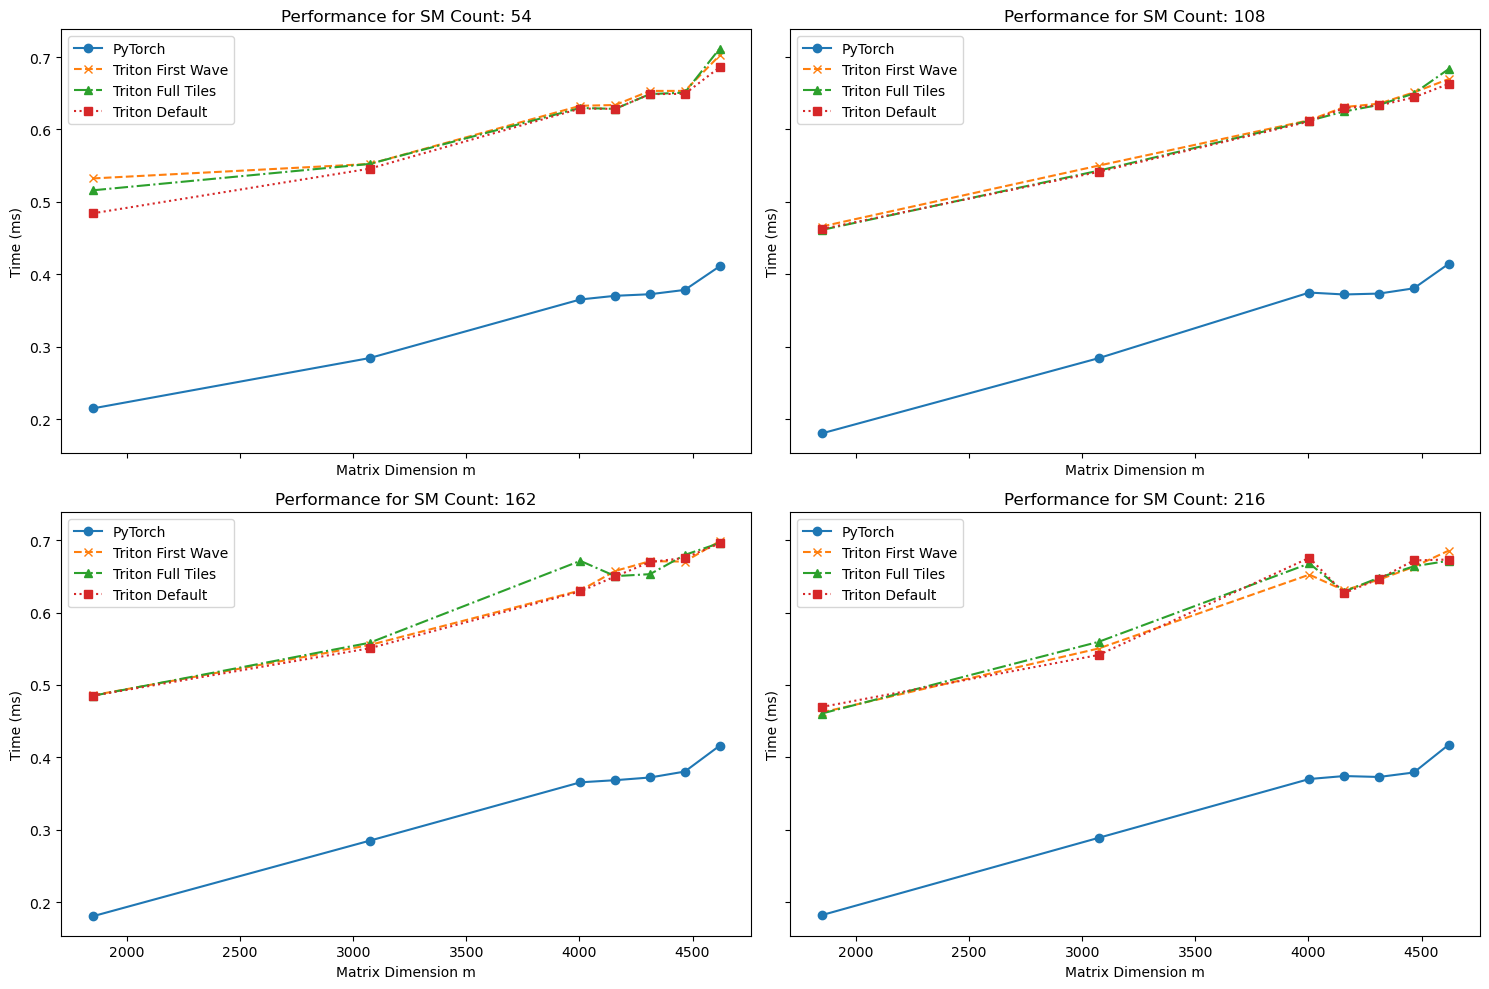

In [16]:
# 将 results 列表转换为 DataFrame
df = pd.DataFrame(results0)

# 获取所有独特的 SM 数量，按排序
unique_sm_counts = sorted(df['sm_count'].unique())

# 设定每个子图的布局
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()  # 将 axes 转换成一维数组以便遍历

# 遍历每个 SM 数量，每个数量一个子图
for i, sm_count in enumerate(unique_sm_counts):
    for gemm_type in ['gemm0']:
        subset = df[(df['gemm'] == gemm_type) & (df['sm_count'] == sm_count)]
        axes[i].plot(subset['m'], subset['PyTorch Time (ms)'], marker='o', linestyle='-', label=f'PyTorch')
        axes[i].plot(subset['m'], subset['Triton Time First Wave (ms)'], marker='x', linestyle='--', label=f'Triton First Wave')
        axes[i].plot(subset['m'], subset['Triton Time Full Tiles (ms)'], marker='^', linestyle='-.', label=f'Triton Full Tiles')
        axes[i].plot(subset['m'], subset['Triton Time Default (ms)'], marker='s', linestyle=':', label=f'Triton Default')

        axes[i].set_xlabel('Matrix Dimension m')
        axes[i].set_ylabel('Time (ms)')
        axes[i].set_title(f'Performance for SM Count: {sm_count}')
        axes[i].legend()

# 调整子图布局
plt.tight_layout()
print("n = 6144, k = 1536")
plt.show()


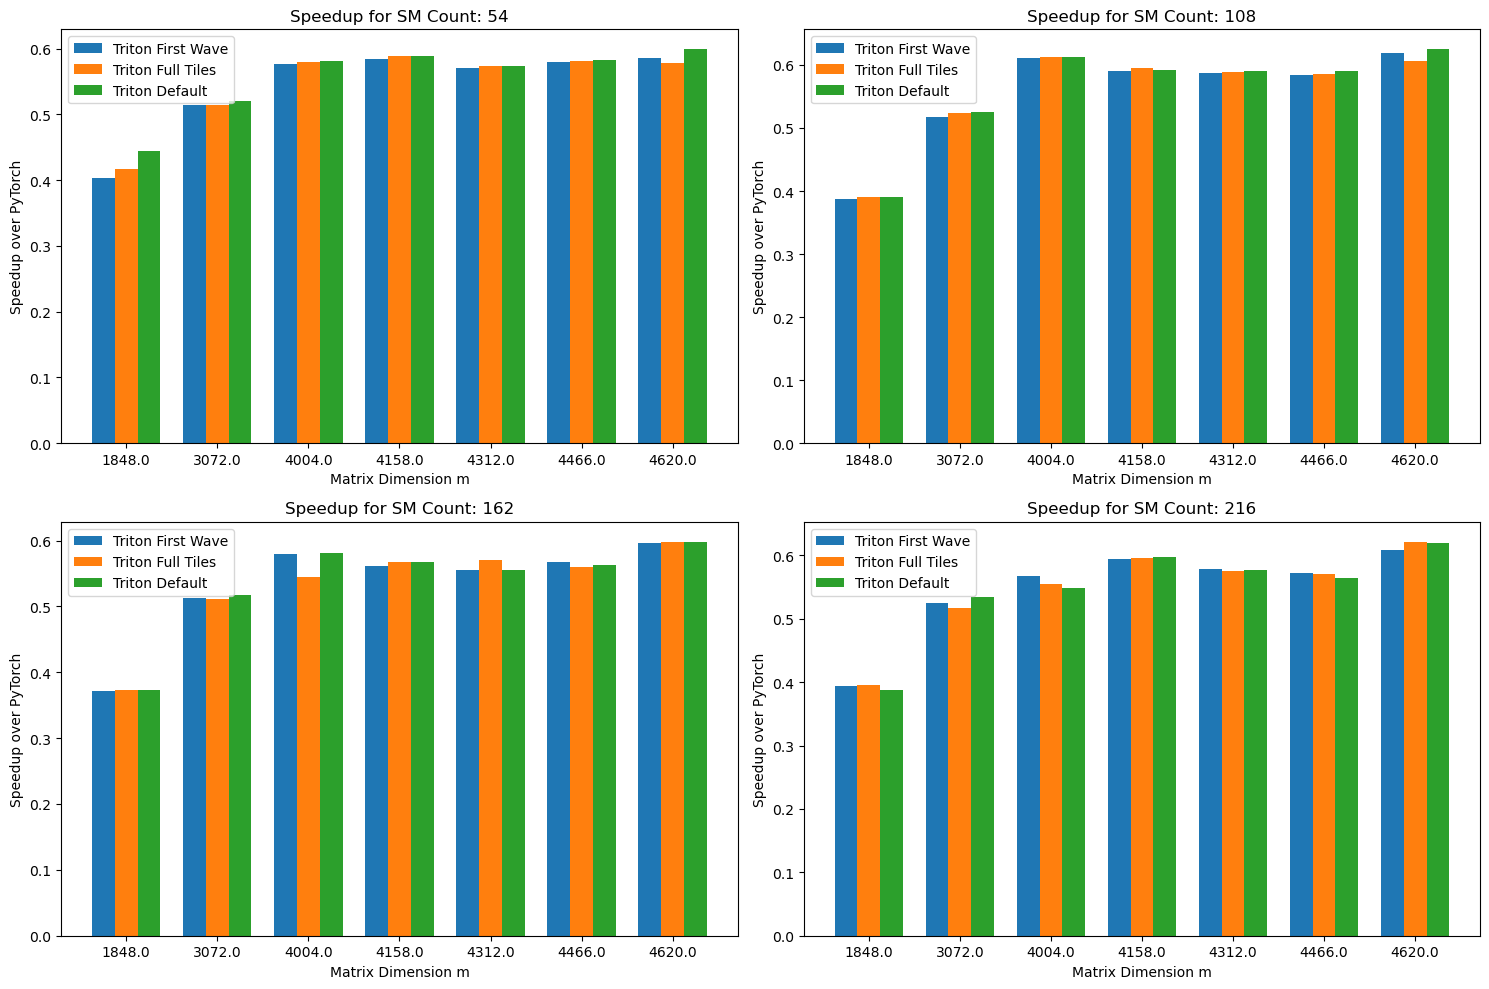

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# 将 results 列表转换为 DataFrame
df = pd.DataFrame(results0)

# 计算加速比
df['First Wave Speedup'] = df['PyTorch Time (ms)'] / df['Triton Time First Wave (ms)']
df['Full Tiles Speedup'] = df['PyTorch Time (ms)'] / df['Triton Time Full Tiles (ms)']
df['Default Speedup'] = df['PyTorch Time (ms)'] / df['Triton Time Default (ms)']

# 获取所有独特的 SM 数量，按排序
unique_sm_counts = sorted(df['sm_count'].unique())

# 设定每个子图的布局
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()  # 将 axes 转换成一维数组以便遍历

# 遍历每个 SM 数量，每个数量一个子图
for i, sm_count in enumerate(unique_sm_counts):
    # 过滤出当前 SM 数量的数据
    subset = df[df['sm_count'] == sm_count]
    
    # 对每个 m 值的加速比数据绘制柱状图
    width = 0.25  # 条形宽度
    m_values = subset['m'].unique()
    
    # 计算每种类型的均值（在有多个 m 值的情况下）
    means_first_wave = subset.groupby('m')['First Wave Speedup'].mean()
    means_full_tiles = subset.groupby('m')['Full Tiles Speedup'].mean()
    means_default = subset.groupby('m')['Default Speedup'].mean()

    # 绘制柱状图
    indices = range(len(m_values))  # m 值的索引位置
    axes[i].bar([x - width for x in indices], means_first_wave, width, label='Triton First Wave')
    axes[i].bar(indices, means_full_tiles, width, label='Triton Full Tiles')
    axes[i].bar([x + width for x in indices], means_default, width, label='Triton Default')

    axes[i].set_xlabel('Matrix Dimension m')
    axes[i].set_ylabel('Speedup over PyTorch')
    axes[i].set_title(f'Speedup for SM Count: {sm_count}')
    axes[i].set_xticks(indices)
    axes[i].set_xticklabels(m_values)
    axes[i].legend()

# 调整子图布局
plt.tight_layout()
plt.show()

n = 1536, k = 6144


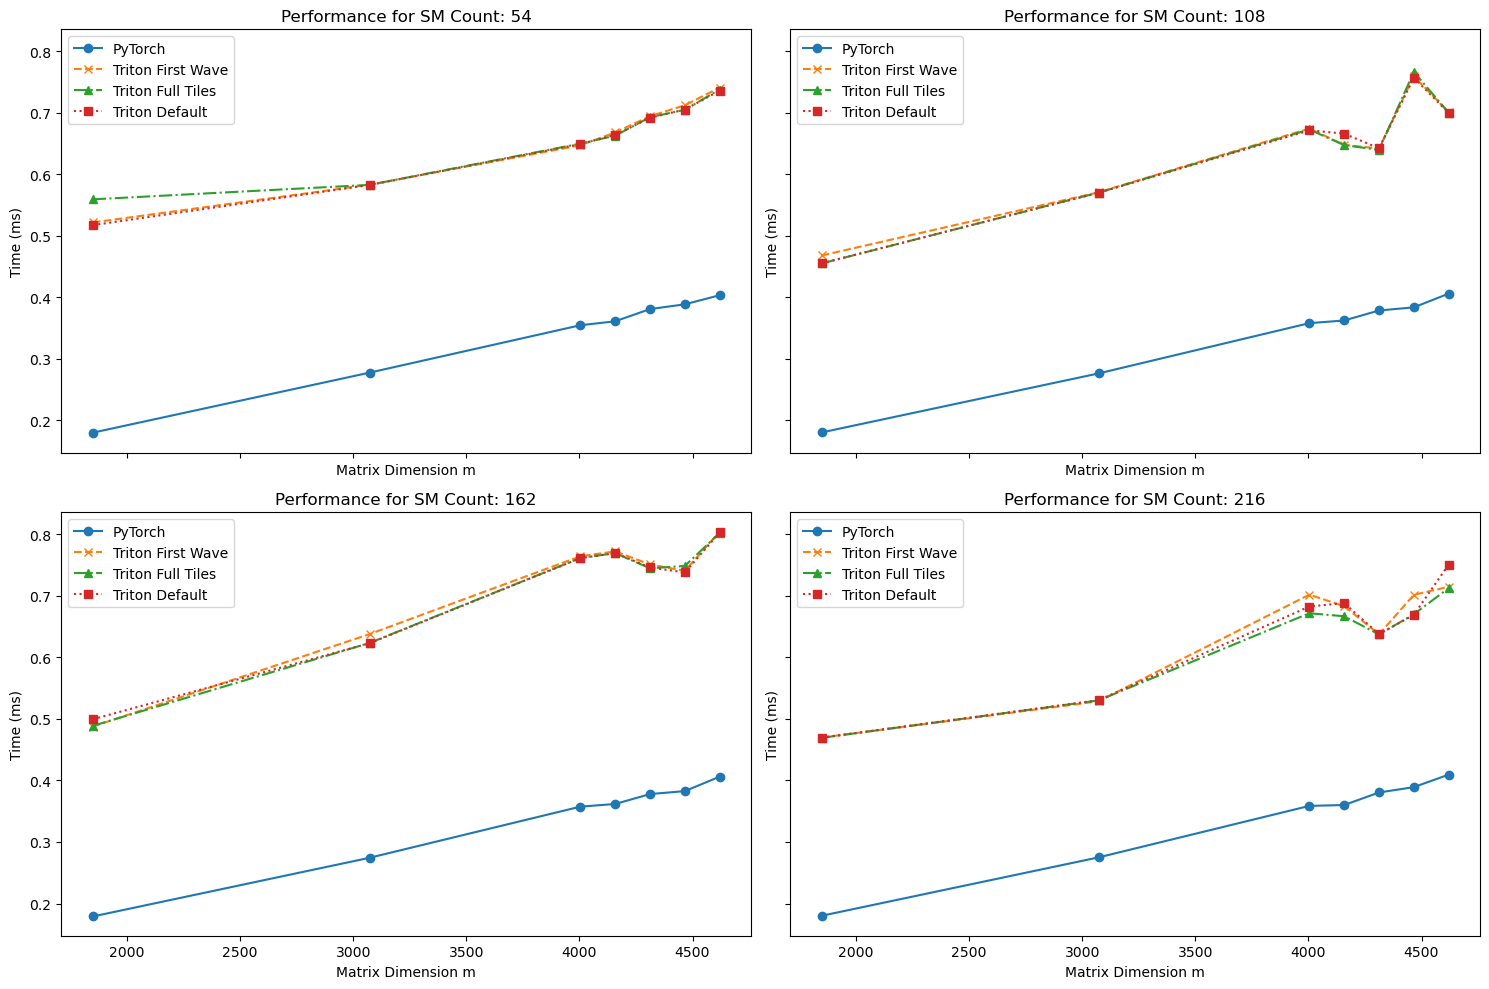

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# 将 results 列表转换为 DataFrame
df = pd.DataFrame(results1)

# 获取所有独特的 SM 数量，按排序
unique_sm_counts = sorted(df['sm_count'].unique())

# 设定每个子图的布局
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()  # 将 axes 转换成一维数组以便遍历

# 遍历每个 SM 数量，每个数量一个子图
for i, sm_count in enumerate(unique_sm_counts):
    for gemm_type in ['gemm1']:
        subset = df[(df['gemm'] == gemm_type) & (df['sm_count'] == sm_count)]
        axes[i].plot(subset['m'], subset['PyTorch Time (ms)'], marker='o', linestyle='-', label=f'PyTorch')
        axes[i].plot(subset['m'], subset['Triton Time First Wave (ms)'], marker='x', linestyle='--', label=f'Triton First Wave')
        axes[i].plot(subset['m'], subset['Triton Time Full Tiles (ms)'], marker='^', linestyle='-.', label=f'Triton Full Tiles')
        axes[i].plot(subset['m'], subset['Triton Time Default (ms)'], marker='s', linestyle=':', label=f'Triton Default')

        axes[i].set_xlabel('Matrix Dimension m')
        axes[i].set_ylabel('Time (ms)')
        axes[i].set_title(f'Performance for SM Count: {sm_count}')
        axes[i].legend()

# 调整子图布局
plt.tight_layout()
print("n = 1536, k = 6144")
plt.show()


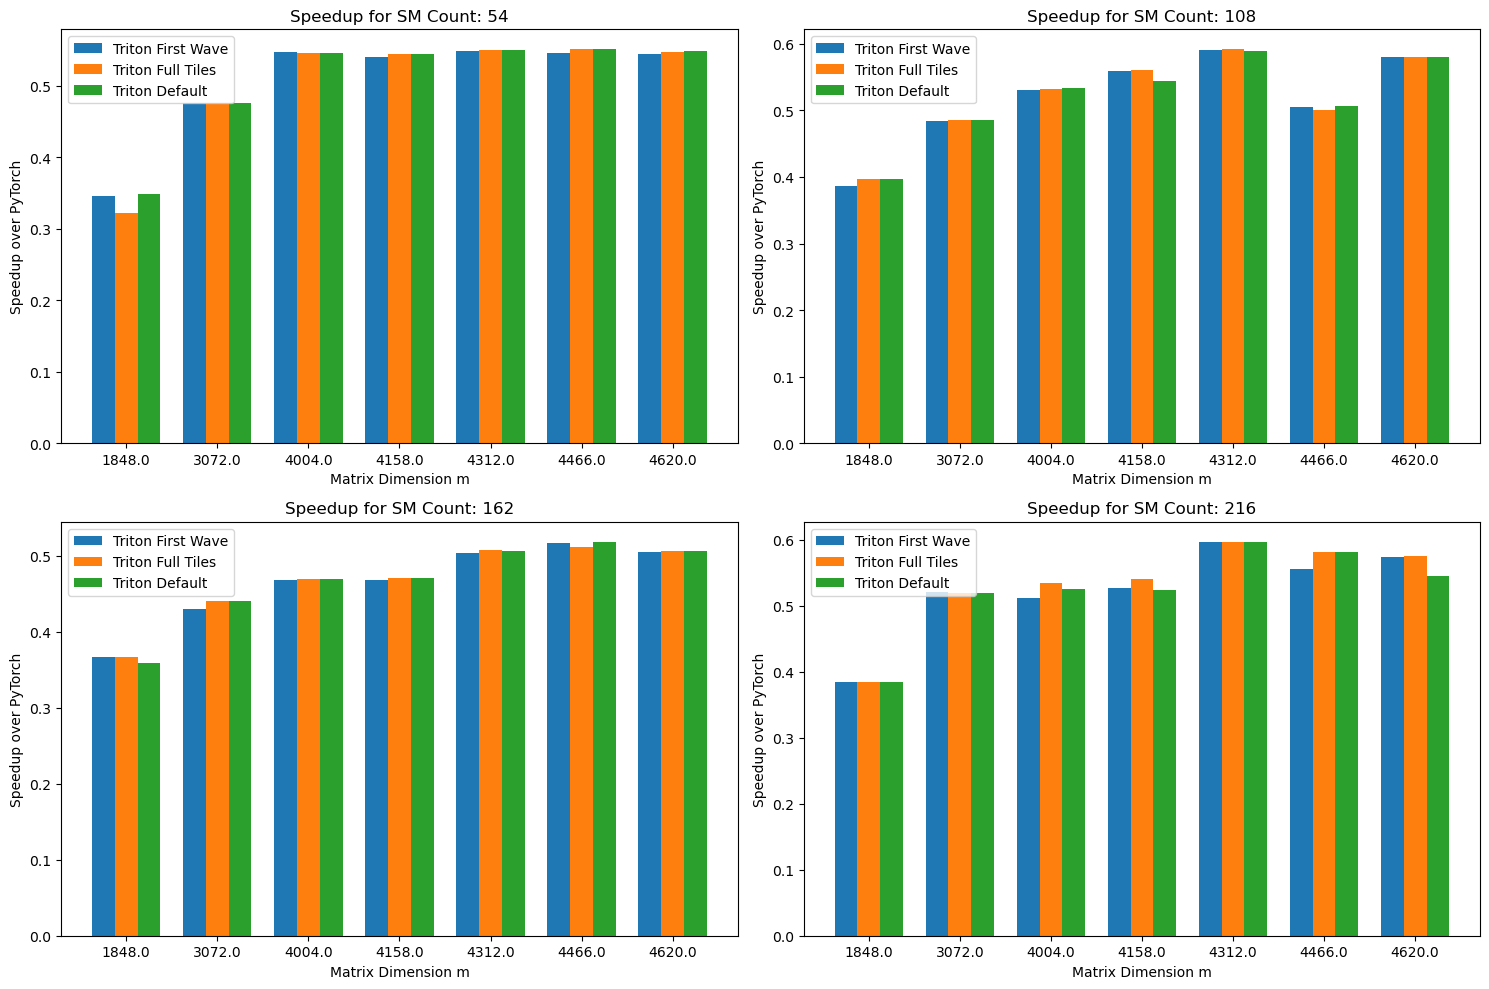

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# 将 results 列表转换为 DataFrame
df = pd.DataFrame(results1)

# 计算加速比
df['First Wave Speedup'] = df['PyTorch Time (ms)'] / df['Triton Time First Wave (ms)']
df['Full Tiles Speedup'] = df['PyTorch Time (ms)'] / df['Triton Time Full Tiles (ms)']
df['Default Speedup'] = df['PyTorch Time (ms)'] / df['Triton Time Default (ms)']

# 获取所有独特的 SM 数量，按排序
unique_sm_counts = sorted(df['sm_count'].unique())

# 设定每个子图的布局
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()  # 将 axes 转换成一维数组以便遍历

# 遍历每个 SM 数量，每个数量一个子图
for i, sm_count in enumerate(unique_sm_counts):
    # 过滤出当前 SM 数量的数据
    subset = df[df['sm_count'] == sm_count]
    
    # 对每个 m 值的加速比数据绘制柱状图
    width = 0.25  # 条形宽度
    m_values = subset['m'].unique()
    
    # 计算每种类型的均值（在有多个 m 值的情况下）
    means_first_wave = subset.groupby('m')['First Wave Speedup'].mean()
    means_full_tiles = subset.groupby('m')['Full Tiles Speedup'].mean()
    means_default = subset.groupby('m')['Default Speedup'].mean()

    # 绘制柱状图
    indices = range(len(m_values))  # m 值的索引位置
    axes[i].bar([x - width for x in indices], means_first_wave, width, label='Triton First Wave')
    axes[i].bar(indices, means_full_tiles, width, label='Triton Full Tiles')
    axes[i].bar([x + width for x in indices], means_default, width, label='Triton Default')

    axes[i].set_xlabel('Matrix Dimension m')
    axes[i].set_ylabel('Speedup over PyTorch')
    axes[i].set_title(f'Speedup for SM Count: {sm_count}')
    axes[i].set_xticks(indices)
    axes[i].set_xticklabels(m_values)
    axes[i].legend()

# 调整子图布局
plt.tight_layout()
plt.show()


#### 单样例测试

In [20]:
# 定义矩阵尺寸
m, n, k = 1848,  1536, 6144
total_sm = 108

# 在 GPU 上生成随机矩阵 A 和 B
A = torch.randn(m, k, device="cuda", dtype=torch.float16)
B = torch.randn(k, n, device="cuda", dtype=torch.float16)

# 启用调试模式并执行矩阵乘法
matmul.set_debug(True)
C = matmul.apply(A, B, total_sm, 128, 128, 32, 4, 4)
matmul.set_debug(False)

# 使用 PyTorch 的矩阵乘法运算符 @ 计算期望的结果矩阵 expected
expected = A @ B

assert torch.allclose(C, expected, atol=1), f"最大误差: {(C - expected).abs().max().item()}\n计算结果:\n{C}\n期望结果:\n{expected}"

pytorch_ms = triton.testing.do_bench(lambda: torch.matmul(A, B))
print(f"PyTorch 矩阵乘法耗时: {pytorch_ms:.2f} ms")

triton_ms = triton.testing.do_bench(lambda: matmul.apply(A, B, total_sm, 128, 128, 32, True, 4, 4))
speedup = pytorch_ms / triton_ms
print(f"Hybrid stream-k 模式 (grid={total_sm}) 耗时: {triton_ms:.2f} ms, 加速比: {speedup:.2f}")

triton_ms = triton.testing.do_bench(lambda: matmul.apply(A, B, total_sm * 2, 128, 128, 32, True, 4, 4))
speedup = pytorch_ms / triton_ms
print(f"Hybrid stream-k 模式 (grid={total_sm * 2}) 耗时: {triton_ms:.2f} ms, 加速比: {speedup:.2f}")

triton_ms = triton.testing.do_bench(lambda: matmul.apply(A, B, 0, 128, 128, 32, True, 4, 4))
speedup = pytorch_ms / triton_ms
print(f"Tile 矩阵乘法 (grid=0) 耗时: {triton_ms:.2f} ms, 加速比: {speedup:.2f}")

矩阵尺寸: M = 1848, N = 1536, K = 6144
块尺寸: BLK_M = 128, BLK_N = 128, BLK_K = 32
总块数: 15 x 12 = 180
first_wave（Stream-K）的 tile 数量: 72
full_tiles（Data-Parallel） 的 tile 数量: 108
总 tiles 数量: 72 + 108 = 180
total_programs_streamk=108
total_blocking_tiles=108
iters_per_tile=192
total_iters_streamk=13824
first_wave：252 registers used, 0 spills
full_tiles：250 registers used, 0 spills
PyTorch 矩阵乘法耗时: 0.21 ms
Hybrid stream-k 模式 (grid=108) 耗时: 0.50 ms, 加速比: 0.41
Hybrid stream-k 模式 (grid=216) 耗时: 0.48 ms, 加速比: 0.43
Tile 矩阵乘法 (grid=0) 耗时: 0.31 ms, 加速比: 0.67


In [19]:
# m, n, k = 128, 128, 6400 # some problem size to test
# m, n, k = 1536, 1792, 6016  # some problem size to test
m, n, k = 1536, 1792, 32000  # some problem size to test
A = torch.randn(m, k, device="cuda", dtype=torch.float16)
B = torch.randn(k, n, device="cuda", dtype=torch.float16)
total_sm = 84

matmul.set_debug(True)
C = matmul.apply(A, B, total_sm, 128, 128, 32, 4, 4)
matmul.set_debug(False)
# 使用 PyTorch 的矩阵乘法运算符 @ 计算期望的结果矩阵 expected
expected = A @ B
assert torch.allclose(C, expected, atol=1), f"max: {(C - expected).abs().max().item()}\n{C}\n{expected}"

# for debugging, uncomment the following line
# exit(0)

pytorch_ms = triton.testing.do_bench(lambda: torch.matmul(A, B))
print(f"PyTorch 矩阵乘法耗时: {pytorch_ms:.2f} ms")

triton_ms = triton.testing.do_bench(lambda: matmul.apply(A, B, total_sm, 128, 128, 32, True, 4, 4))
speedup = pytorch_ms / triton_ms
print(f"Hybrid stream-k 模式 (grid={total_sm}) 耗时: {triton_ms:.2f} ms, 加速比: {speedup:.2f}")

triton_ms = triton.testing.do_bench(lambda: matmul.apply(A, B, total_sm * 2, 128, 128, 32, True, 4, 4))
speedup = pytorch_ms / triton_ms
print(f"Hybrid stream-k 模式 (grid={total_sm * 2}) 耗时: {triton_ms:.2f} ms, 加速比: {speedup:.2f}")

triton_ms = triton.testing.do_bench(lambda: matmul.apply(A, B, 0, 128, 128, 32, True, 4, 4))
speedup = pytorch_ms / triton_ms
print(f"Tile 矩阵乘法 (grid=0) 耗时: {triton_ms:.2f} ms, 加速比: {speedup:.2f}")

矩阵尺寸: M = 1536, N = 1792, K = 32000
块尺寸: BLK_M = 128, BLK_N = 128, BLK_K = 32
总块数: 12 x 14 = 168
first_wave（Stream-K）的 tile 数量: 0
full_tiles（Data-Parallel） 的 tile 数量: 168
总 tiles 数量: 0 + 168 = 168
total_programs_streamk=84
total_blocking_tiles=168
iters_per_tile=1000
total_iters_streamk=0
full_tiles：250 registers used, 0 spills
PyTorch 矩阵乘法耗时: 0.72 ms
Hybrid stream-k 模式 (grid=84) 耗时: 0.97 ms, 加速比: 0.75
Hybrid stream-k 模式 (grid=168) 耗时: 0.96 ms, 加速比: 0.75
Tile 矩阵乘法 (grid=0) 耗时: 0.99 ms, 加速比: 0.73


#### 多样例测试
- 随机生成测试矩阵

In [43]:
num_samples = 1000  # 32768 # 生成的样本数量
step = 256                  # 样本尺寸的步长
total_sm = 108
# 使用 torch.logspace 生成从 step 到 8192 的对数刻度值，然后通过四舍五入和去重生成唯一的尺寸值
values = ((torch.logspace(torch.tensor(step).log2(), torch.tensor(25600).log2(), num_samples, base=2) / step).round() * step).unique().tolist()
# 通过尺寸值生成所有可能的(m, n, k) 并从中随机抽取 num_samples 个组合
shapes = [(int(m), int(n), int(k)) for m in values for n in values for k in values]
shapes = random.sample(shapes, num_samples)
assert len(shapes) == num_samples

In [13]:
num_samples = 1000  # 定义生成的样本数量
step = 256          # 定义样本尺寸的步长
total_sm = 108      # 定义SM的数量

values = ((torch.logspace(torch.tensor(step).log2(), torch.tensor(25600).log2(), num_samples, base=2) / step).round() * step).unique().tolist()

shapes = [(int(m), int(n), 10240) for m in values for n in values]
random_samples = random.sample(shapes, num_samples)  

df_shapes = pd.DataFrame(random_samples, columns=['m', 'n', 'k'])
random_samples = df_shapes.sort_values(by=['m', 'n'])  # 按 m 和 k 排序

# 打印一些样本以确认生成是否正确
print(random_samples[:10])  # 打印前10个样本查看

       m      n      k
577  256   2816  10240
223  256  10496  10240
373  256  16128  10240
571  256  18176  10240
790  256  19456  10240
518  256  19968  10240
328  256  22272  10240
789  512    512  10240
887  512   2816  10240
969  512   3584  10240


In [11]:
# 定义 benchmark 函数
def benchmark(m, n, k):
    A = torch.randn(m, k, device="cuda", dtype=torch.float16)
    B = torch.randn(k, n, device="cuda", dtype=torch.float16)
    expected = A @ B

    pytorch_time = testing.do_bench(lambda: A @ B)
    triton_measures = []

    for two_tiles in [True, False]:
        # sm_choices = random.sample(range(2, total_sm * 2, 2), 10)  # 随机选择 SM 数量
        # sm_choices += [total_sm, total_sm * 2]  # 包括基础和两倍 SM 数量
        # for sm in sm_choices:
        triton_time = testing.do_bench(lambda: matmul.apply(A, B, total_sm, 128, 128, 32, two_tiles, 4, 4))
        output = matmul.apply(A, B, total_sm, 128, 128, 32, two_tiles, 4, 4)
        max_disc = (output - expected).abs().max().item()
        assert max_disc <= 5.0
        triton_measures.append({'sm': total_sm, 'two_tiles': two_tiles, 'triton_time': triton_time, 'max_disc': max_disc})

    best_measure = min(triton_measures, key=lambda x: x['triton_time'])
    speedup = pytorch_time / best_measure['triton_time']
    return {'shape': (m, n, k), 'pytorch_time': pytorch_time, 'best_measure': best_measure, 'speedup': speedup}

In [14]:
results = []
for idx, row in random_samples.iterrows():
    m, n, k = row['m'], row['n'], row['k']
    result = benchmark(m, n, k)
    results.append(result)

    # 每次测试后输出当前进度和该形状的结果
    print(f"Tested {idx + 1}/{num_samples}: Shape ({m}, {n}, {k}), PyTorch Time {result['pytorch_time']:.2f} ms, "
          f"Best Triton Time {result['best_measure']['triton_time']:.2f} ms, Speedup {result['speedup']:.2f}, "
          f"Max Discrepancy {result['best_measure']['max_disc']}")

Tested 578/1000: Shape (256, 2816, 10240), PyTorch Time 0.16 ms, Best Triton Time 0.40 ms, Speedup 0.41, Max Discrepancy 0.5
Tested 224/1000: Shape (256, 10496, 10240), PyTorch Time 0.28 ms, Best Triton Time 0.56 ms, Speedup 0.50, Max Discrepancy 0.5
Tested 374/1000: Shape (256, 16128, 10240), PyTorch Time 0.41 ms, Best Triton Time 0.69 ms, Speedup 0.60, Max Discrepancy 0.5
Tested 572/1000: Shape (256, 18176, 10240), PyTorch Time 0.43 ms, Best Triton Time 0.75 ms, Speedup 0.57, Max Discrepancy 0.5
Tested 791/1000: Shape (256, 19456, 10240), PyTorch Time 0.46 ms, Best Triton Time 0.78 ms, Speedup 0.60, Max Discrepancy 0.5
Tested 519/1000: Shape (256, 19968, 10240), PyTorch Time 0.47 ms, Best Triton Time 0.80 ms, Speedup 0.58, Max Discrepancy 0.25
Tested 329/1000: Shape (256, 22272, 10240), PyTorch Time 0.52 ms, Best Triton Time 0.81 ms, Speedup 0.63, Max Discrepancy 0.5
Tested 790/1000: Shape (512, 512, 10240), PyTorch Time 0.09 ms, Best Triton Time 0.33 ms, Speedup 0.26, Max Discrepanc

: 

In [61]:
results = []
for idx, (m, n, k) in enumerate(random_samples):
    result = benchmark(m, n, k)
    results.append(result)

    # 每次测试后输出当前进度和该形状的结果
    print(f"Tested {idx + 1}/{num_samples}: Shape {result['shape']}, PyTorch Time {result['pytorch_time']:.2f} ms, "
          f"Best Triton Time {result['best_measure']['triton_time']:.2f} ms, Speedup {result['speedup']:.2f}, "
          f"Max Discrepancy {result['best_measure']['max_disc']}")

ValueError: not enough values to unpack (expected 3, got 1)

In [42]:
# 找到加速比最高的结果并输出
best_result = max(results, key=lambda x: x['speedup'])
print(f"形状: {best_result['shape']}, 加速比: {best_result['speedup']:.2f}, PyTorch 时间: {best_result['pytorch_time']:.2f} ms, 最佳 Triton 配置: {best_result['best_measure']}")

ValueError: max() arg is an empty sequence

In [23]:
results = []
for idx, (m, n, k) in enumerate(shapes):
    # 每处理 10 个样本，输出当前进度和平均加速比
    if idx % 10 == 0 and idx > 0:
        speedups = [r["speedup"] for r in results]
        print(f"{idx}/{num_samples} - average speedup: {sum(speedups) / len(speedups):.3f}")

    A = torch.randn(m, k, device="cuda", dtype=torch.float16)
    B = torch.randn(k, n, device="cuda", dtype=torch.float16)
    output: Optional[torch.Tensor] = None

    def wrapper_matmul(*args, **kwargs):
        global output
        output = matmul.apply(*args, **kwargs)
        return output
    
    # baseline: pytorch
    expected = A @ B
    pytorch_ms = triton.testing.do_bench(lambda: A @ B)
    # print(f"PyTorch 矩阵尺寸: {m} x {n} x {k}, 耗时: {pytorch_ms:.2f} ms")

    # test: triton
    measures = list()
    for two_tiles in [True, False]:
        nb_sm = [total_sm, total_sm * 2]
        total_tile = (m // 128) * (n // 128)
        if total_tile < total_sm * 2:
            nb_sm.append(total_tile)
        nb_sm += random.sample(range(2, total_sm * 2, 2), 10) #　从 2 到 total_sm * 2 的偶数范围内随机选择 10 个
        for sm in nb_sm:
            triton_ms = triton.testing.do_bench(lambda: wrapper_matmul(A, B, sm, 128, 128, 32, two_tiles, 4, 4))
            max_disc = (output - expected).abs().max().item()
            # large tolerance to accomodate for large K (rounding due to half precision), we just want to catch bugs.
            assert max_disc <= 5., f"pb size: {m}x{n}x{k} - max discrepancy: {max_disc} - sm: {sm}, 2 tiles: {two_tiles}\n{output}\n{expected}"
            info = {"two_tiles": two_tiles,
                    "sm": sm,
                    "disc": max_disc,
                    "triton_ms": triton_ms}
            measures.append(info)
            print(f"配置: sm = {sm}, two_tiles = {two_tiles}, 耗时: {triton_ms:.2f} ms, 最大误差: {max_disc}")

    best_triton_ms = min([m["triton_ms"] for m in measures])
    best_measure = next(m for m in measures if m["triton_ms"] == best_triton_ms)
    d = {"m": m, "n": n, "k": k,
         "triton": measures,
         "pytorch_ms": pytorch_ms,
         "best_measure": best_measure,
         "speedup": pytorch_ms / best_triton_ms}
    results.append(d)
    # print(f"最佳耗时: {best_triton_ms:.2f} ms, 加速比: {speedup:.2f}")
    measures = list()

results.sort(key=lambda x: x["speedup"], reverse=True)
print("所有测试完成，按加速比排序结果：")
for result in results:
    print(f"矩阵尺寸: {result['m']} x {result['n']} x {result['k']}, PyTorch 耗时: {result['pytorch_ms']:.2f} ms, "
          f"最佳 Triton 配置: SM 数量 = {result['best_measure']['sm']}, 两块 tiles = {result['best_measure']['two_tiles']}, "
          f"耗时: {result['best_measure']['triton_ms']:.2f} ms, 加速比: {result['speedup']:.2f}")

配置: sm = 108, two_tiles = True, 耗时: 0.40 ms, 最大误差: 0.0625
配置: sm = 216, two_tiles = True, 耗时: 0.39 ms, 最大误差: 0.0625
配置: sm = 142, two_tiles = True, 耗时: 0.40 ms, 最大误差: 0.0625
配置: sm = 116, two_tiles = True, 耗时: 0.37 ms, 最大误差: 0.0625
配置: sm = 54, two_tiles = True, 耗时: 0.37 ms, 最大误差: 0.0625
配置: sm = 168, two_tiles = True, 耗时: 0.37 ms, 最大误差: 0.0625
配置: sm = 12, two_tiles = True, 耗时: 0.20 ms, 最大误差: 0.0
配置: sm = 26, two_tiles = True, 耗时: 0.37 ms, 最大误差: 0.0625
配置: sm = 46, two_tiles = True, 耗时: 0.36 ms, 最大误差: 0.0625
配置: sm = 42, two_tiles = True, 耗时: 0.36 ms, 最大误差: 0.0625
配置: sm = 6, two_tiles = True, 耗时: 0.19 ms, 最大误差: 0.0
配置: sm = 4, two_tiles = True, 耗时: 0.19 ms, 最大误差: 0.0
配置: sm = 108, two_tiles = False, 耗时: 0.36 ms, 最大误差: 0.0625
配置: sm = 216, two_tiles = False, 耗时: 0.37 ms, 最大误差: 0.0625
配置: sm = 176, two_tiles = False, 耗时: 0.36 ms, 最大误差: 0.0625
配置: sm = 70, two_tiles = False, 耗时: 0.35 ms, 最大误差: 0.0625
配置: sm = 92, two_tiles = False, 耗时: 0.35 ms, 最大误差: 0.0625
配置: sm = 202, two_tiles = Fal

KeyboardInterrupt: 

In [22]:
with open("results.json", "w") as f:
    json.dump(results, f, indent=4)

In [23]:
# 32760/32768 - average speedup: 0.962 (A100)
# 990/1000 - average speedup: 1.063 (3090 RTX with while loop and 2 tiles disabled / enabled)

# 990/1000 - average speedup: 1.016（V100）
# 990/32768 - average speedup: 0.608（A100）
# 100/32768 - average speedup: 0.901

### 详解
- 矩阵乘法 $C=A×B$，其中 $A$ 的大小为 $m×k$，$B$ 的大小为 $k×n$

- $m=1536$，$n=1792$，$k=6016$

- $BLOCK\_M=128$，$BLOCK\_N=128$，$BLOCK\_K=32$

- 需要处理的块数量：
    - $ total\_blocks\_M = \lceil \frac{1536}{128} \rceil = 12 $
    - $ total\_blocks\_N = \lceil \frac{1792}{128} \rceil = 14 $
    - 总块数 $ total\_tiles = total\_blocks\_M \times total\_blocks\_N = 12 \times 14 = 168 $
- 每个块的迭代次数：$ iters\_per\_tile = \lceil \frac{6016}{32} \rceil = 188 $

#### $total\_programs\_streamk = 82$
- 总共使用 82 个SM来进行并行计算

- $ total\_tiles\_streamk = total\_tiles \% total\_programs\_streamk = 168 \% 82 = 4 $，由`first_wave` 处理，每个SM处理9次完整迭代和第10个迭代中的部分（32次）任务
    - $ total\_full\_tiles\_streamk = \frac{total\_iters\_streamk}{total\_programs\_streamk} = \frac{4 \times 188}{82} \approx 9 $
    - $ total\_partial\_tiles\_streamk = (4 \times 188) \% 82 = 32 $
- $total\_blocking\_tiles = total\_tiles - total\_tiles\_streamk = 168 - 4 = 164$，由 `full_tiles` 处理

#### $total\_programs\_streamk = 84（V100）$
- 总共使用 84 个SM来进行并行计算

- $ total\_tiles\_streamk = total\_tiles \% total\_programs\_streamk = 168 \% 84 = 0 $
- $total\_blocking\_tiles = total\_tiles - total\_tiles\_streamk = 168 - 0 = 168$，所有的计算块都由 `full_tiles` 处理

In [24]:
10/100 - average speedup: 0.909
20/100 - average speedup: 0.919
30/100 - average speedup: 0.978
40/100 - average speedup: 0.972
50/100 - average speedup: 0.999
60/100 - average speedup: 1.005
70/100 - average speedup: 1.008
80/100 - average speedup: 0.997
90/100 - average speedup: 1.031
所有测试完成，按加速比排序结果：
矩阵尺寸: 5632 x 7168 x 3328, PyTorch 耗时: 19.04 ms, 最佳 Triton 配置: SM 数量 = 96, 两块 tiles = True, 耗时: 9.03 ms, 加速比: 2.11
矩阵尺寸: 2816 x 3584 x 4096, PyTorch 耗时: 5.69 ms, 最佳 Triton 配置: SM 数量 = 56, 两块 tiles = False, 耗时: 2.76 ms, 加速比: 2.07
矩阵尺寸: 5376 x 7680 x 7680, PyTorch 耗时: 42.28 ms, 最佳 Triton 配置: SM 数量 = 168, 两块 tiles = True, 耗时: 21.24 ms, 加速比: 1.99
矩阵尺寸: 3584 x 256 x 512, PyTorch 耗时: 0.09 ms, 最佳 Triton 配置: SM 数量 = 4, 两块 tiles = False, 耗时: 0.05 ms, 加速比: 1.84
矩阵尺寸: 7680 x 4352 x 5120, PyTorch 耗时: 23.18 ms, 最佳 Triton 配置: SM 数量 = 48, 两块 tiles = False, 耗时: 12.65 ms, 加速比: 1.83
矩阵尺寸: 2560 x 6656 x 7936, PyTorch 耗时: 16.11 ms, 最佳 Triton 配置: SM 数量 = 104, 两块 tiles = True, 耗时: 9.21 ms, 加速比: 1.75
矩阵尺寸: 7424 x 6912 x 3840, PyTorch 耗时: 22.82 ms, 最佳 Triton 配置: SM 数量 = 26, 两块 tiles = True, 耗时: 13.46 ms, 加速比: 1.70
矩阵尺寸: 7680 x 6400 x 4608, PyTorch 耗时: 24.52 ms, 最佳 Triton 配置: SM 数量 = 6, 两块 tiles = True, 耗时: 14.83 ms, 加速比: 1.65
矩阵尺寸: 7936 x 4096 x 7680, PyTorch 耗时: 27.25 ms, 最佳 Triton 配置: SM 数量 = 42, 两块 tiles = True, 耗时: 18.04 ms, 加速比: 1.51
矩阵尺寸: 2816 x 256 x 8192, PyTorch 耗时: 0.52 ms, 最佳 Triton 配置: SM 数量 = 130, 两块 tiles = False, 耗时: 0.35 ms, 加速比: 1.50
矩阵尺寸: 7680 x 3840 x 7424, PyTorch 耗时: 20.63 ms, 最佳 Triton 配置: SM 数量 = 36, 两块 tiles = True, 耗时: 13.97 ms, 加速比: 1.48
矩阵尺寸: 5888 x 1024 x 256, PyTorch 耗时: 0.15 ms, 最佳 Triton 配置: SM 数量 = 4, 两块 tiles = False, 耗时: 0.10 ms, 加速比: 1.48
矩阵尺寸: 2304 x 512 x 1280, PyTorch 耗时: 0.15 ms, 最佳 Triton 配置: SM 数量 = 72, 两块 tiles = False, 耗时: 0.11 ms, 加速比: 1.47
矩阵尺寸: 3328 x 768 x 2304, PyTorch 耗时: 0.41 ms, 最佳 Triton 配置: SM 数量 = 52, 两块 tiles = True, 耗时: 0.28 ms, 加速比: 1.46
矩阵尺寸: 5120 x 7680 x 4096, PyTorch 耗时: 15.03 ms, 最佳 Triton 配置: SM 数量 = 134, 两块 tiles = True, 耗时: 11.10 ms, 加速比: 1.35
矩阵尺寸: 3584 x 512 x 3840, PyTorch 耗时: 0.57 ms, 最佳 Triton 配置: SM 数量 = 112, 两块 tiles = False, 耗时: 0.44 ms, 加速比: 1.31
矩阵尺寸: 6912 x 2048 x 512, PyTorch 耗时: 0.59 ms, 最佳 Triton 配置: SM 数量 = 144, 两块 tiles = False, 耗时: 0.46 ms, 加速比: 1.28
矩阵尺寸: 6400 x 1024 x 1536, PyTorch 耗时: 0.61 ms, 最佳 Triton 配置: SM 数量 = 10, 两块 tiles = True, 耗时: 0.49 ms, 加速比: 1.24
矩阵尺寸: 4352 x 4096 x 7680, PyTorch 耗时: 11.93 ms, 最佳 Triton 配置: SM 数量 = 38, 两块 tiles = True, 耗时: 9.66 ms, 加速比: 1.23
矩阵尺寸: 768 x 7680 x 256, PyTorch 耗时: 0.12 ms, 最佳 Triton 配置: SM 数量 = 6, 两块 tiles = False, 耗时: 0.10 ms, 加速比: 1.22
矩阵尺寸: 3072 x 768 x 2816, PyTorch 耗时: 0.44 ms, 最佳 Triton 配置: SM 数量 = 144, 两块 tiles = False, 耗时: 0.36 ms, 加速比: 1.21
矩阵尺寸: 512 x 512 x 5376, PyTorch 耗时: 0.16 ms, 最佳 Triton 配置: SM 数量 = 152, 两块 tiles = False, 耗时: 0.13 ms, 加速比: 1.20
矩阵尺寸: 1536 x 512 x 5888, PyTorch 耗时: 0.38 ms, 最佳 Triton 配置: SM 数量 = 120, 两块 tiles = False, 耗时: 0.32 ms, 加速比: 1.20
矩阵尺寸: 3072 x 7680 x 256, PyTorch 耗时: 0.49 ms, 最佳 Triton 配置: SM 数量 = 80, 两块 tiles = False, 耗时: 0.41 ms, 加速比: 1.19
矩阵尺寸: 512 x 6144 x 4608, PyTorch 耗时: 1.07 ms, 最佳 Triton 配置: SM 数量 = 128, 两块 tiles = True, 耗时: 0.93 ms, 加速比: 1.15
矩阵尺寸: 2816 x 1024 x 256, PyTorch 耗时: 0.07 ms, 最佳 Triton 配置: SM 数量 = 4, 两块 tiles = True, 耗时: 0.06 ms, 加速比: 1.15
矩阵尺寸: 1536 x 1792 x 5120, PyTorch 耗时: 1.00 ms, 最佳 Triton 配置: SM 数量 = 156, 两块 tiles = False, 耗时: 0.87 ms, 加速比: 1.15
矩阵尺寸: 1536 x 2816 x 6400, PyTorch 耗时: 2.10 ms, 最佳 Triton 配置: SM 数量 = 6, 两块 tiles = False, 耗时: 2.09 ms, 加速比: 1.00
矩阵尺寸: 7680 x 3840 x 2048, PyTorch 耗时: 2.85 ms, 最佳 Triton 配置: SM 数量 = 84, 两块 tiles = True, 耗时: 2.86 ms, 加速比: 1.00
矩阵尺寸: 6912 x 4352 x 256, PyTorch 耗时: 0.58 ms, 最佳 Triton 配置: SM 数量 = 34, 两块 tiles = False, 耗时: 0.59 ms, 加速比: 0.99
矩阵尺寸: 5376 x 5376 x 3840, PyTorch 耗时: 8.12 ms, 最佳 Triton 配置: SM 数量 = 42, 两块 tiles = True, 耗时: 8.25 ms, 加速比: 0.98
矩阵尺寸: 3840 x 2048 x 2304, PyTorch 耗时: 0.94 ms, 最佳 Triton 配置: SM 数量 = 24, 两块 tiles = False, 耗时: 0.96 ms, 加速比: 0.98
矩阵尺寸: 3840 x 512 x 5632, PyTorch 耗时: 0.75 ms, 最佳 Triton 配置: SM 数量 = 120, 两块 tiles = True, 耗时: 0.76 ms, 加速比: 0.98
矩阵尺寸: 5376 x 7168 x 4352, PyTorch 耗时: 10.62 ms, 最佳 Triton 配置: SM 数量 = 168, 两块 tiles = True, 耗时: 10.88 ms, 加速比: 0.98
矩阵尺寸: 2048 x 4608 x 6912, PyTorch 耗时: 3.93 ms, 最佳 Triton 配置: SM 数量 = 8, 两块 tiles = True, 耗时: 4.07 ms, 加速比: 0.97
矩阵尺寸: 2304 x 8192 x 768, PyTorch 耗时: 1.13 ms, 最佳 Triton 配置: SM 数量 = 96, 两块 tiles = False, 耗时: 1.17 ms, 加速比: 0.96
矩阵尺寸: 768 x 3840 x 5888, PyTorch 耗时: 1.30 ms, 最佳 Triton 配置: SM 数量 = 142, 两块 tiles = True, 耗时: 1.35 ms, 加速比: 0.96
矩阵尺寸: 7168 x 7424 x 6144, PyTorch 耗时: 14.87 ms, 最佳 Triton 配置: SM 数量 = 168, 两块 tiles = False, 耗时: 15.49 ms, 加速比: 0.96
矩阵尺寸: 7936 x 7680 x 4608, PyTorch 耗时: 19.01 ms, 最佳 Triton 配置: SM 数量 = 66, 两块 tiles = True, 耗时: 20.20 ms, 加速比: 0.94
矩阵尺寸: 5888 x 1792 x 1536, PyTorch 耗时: 0.98 ms, 最佳 Triton 配置: SM 数量 = 8, 两块 tiles = False, 耗时: 1.04 ms, 加速比: 0.94
矩阵尺寸: 4352 x 6400 x 768, PyTorch 耗时: 1.30 ms, 最佳 Triton 配置: SM 数量 = 20, 两块 tiles = False, 耗时: 1.39 ms, 加速比: 0.94
矩阵尺寸: 3840 x 6400 x 768, PyTorch 耗时: 1.39 ms, 最佳 Triton 配置: SM 数量 = 10, 两块 tiles = False, 耗时: 1.49 ms, 加速比: 0.94
矩阵尺寸: 4608 x 2304 x 7936, PyTorch 耗时: 6.25 ms, 最佳 Triton 配置: SM 数量 = 158, 两块 tiles = False, 耗时: 6.72 ms, 加速比: 0.93
矩阵尺寸: 7424 x 256 x 5632, PyTorch 耗时: 0.69 ms, 最佳 Triton 配置: SM 数量 = 116, 两块 tiles = True, 耗时: 0.75 ms, 加速比: 0.92
矩阵尺寸: 768 x 6912 x 6656, PyTorch 耗时: 2.38 ms, 最佳 Triton 配置: SM 数量 = 20, 两块 tiles = False, 耗时: 2.58 ms, 加速比: 0.92
矩阵尺寸: 6656 x 4352 x 6144, PyTorch 耗时: 8.94 ms, 最佳 Triton 配置: SM 数量 = 96, 两块 tiles = False, 耗时: 9.70 ms, 加速比: 0.92
矩阵尺寸: 3328 x 2304 x 3840, PyTorch 耗时: 1.86 ms, 最佳 Triton 配置: SM 数量 = 52, 两块 tiles = False, 耗时: 2.02 ms, 加速比: 0.92
矩阵尺寸: 6912 x 6656 x 3328, PyTorch 耗时: 11.10 ms, 最佳 Triton 配置: SM 数量 = 166, 两块 tiles = True, 耗时: 12.09 ms, 加速比: 0.92
矩阵尺寸: 6144 x 1024 x 3328, PyTorch 耗时: 1.32 ms, 最佳 Triton 配置: SM 数量 = 6, 两块 tiles = True, 耗时: 1.45 ms, 加速比: 0.91
矩阵尺寸: 3584 x 2304 x 2304, PyTorch 耗时: 1.37 ms, 最佳 Triton 配置: SM 数量 = 168, 两块 tiles = False, 耗时: 1.50 ms, 加速比: 0.91
矩阵尺寸: 5632 x 4864 x 768, PyTorch 耗时: 1.55 ms, 最佳 Triton 配置: SM 数量 = 152, 两块 tiles = False, 耗时: 1.71 ms, 加速比: 0.91
矩阵尺寸: 5376 x 4096 x 768, PyTorch 耗时: 1.18 ms, 最佳 Triton 配置: SM 数量 = 84, 两块 tiles = False, 耗时: 1.30 ms, 加速比: 0.90
矩阵尺寸: 2560 x 5632 x 4608, PyTorch 耗时: 4.69 ms, 最佳 Triton 配置: SM 数量 = 4, 两块 tiles = False, 耗时: 5.21 ms, 加速比: 0.90
矩阵尺寸: 7424 x 3840 x 8192, PyTorch 耗时: 12.62 ms, 最佳 Triton 配置: SM 数量 = 100, 两块 tiles = True, 耗时: 14.03 ms, 加速比: 0.90
矩阵尺寸: 2048 x 7168 x 1792, PyTorch 耗时: 1.78 ms, 最佳 Triton 配置: SM 数量 = 32, 两块 tiles = True, 耗时: 1.98 ms, 加速比: 0.90
矩阵尺寸: 2048 x 4352 x 7168, PyTorch 耗时: 3.93 ms, 最佳 Triton 配置: SM 数量 = 4, 两块 tiles = True, 耗时: 4.41 ms, 加速比: 0.89
矩阵尺寸: 6144 x 3840 x 3328, PyTorch 耗时: 5.28 ms, 最佳 Triton 配置: SM 数量 = 8, 两块 tiles = True, 耗时: 5.94 ms, 加速比: 0.89
矩阵尺寸: 7680 x 3584 x 1536, PyTorch 耗时: 2.63 ms, 最佳 Triton 配置: SM 数量 = 20, 两块 tiles = True, 耗时: 2.96 ms, 加速比: 0.89
矩阵尺寸: 8192 x 4096 x 4864, PyTorch 耗时: 10.77 ms, 最佳 Triton 配置: SM 数量 = 168, 两块 tiles = True, 耗时: 12.13 ms, 加速比: 0.89
矩阵尺寸: 7424 x 1792 x 3840, PyTorch 耗时: 2.90 ms, 最佳 Triton 配置: SM 数量 = 12, 两块 tiles = True, 耗时: 3.27 ms, 加速比: 0.89
矩阵尺寸: 2560 x 3584 x 1280, PyTorch 耗时: 0.65 ms, 最佳 Triton 配置: SM 数量 = 16, 两块 tiles = False, 耗时: 0.73 ms, 加速比: 0.89
矩阵尺寸: 5376 x 4352 x 1280, PyTorch 耗时: 2.19 ms, 最佳 Triton 配置: SM 数量 = 34, 两块 tiles = False, 耗时: 2.48 ms, 加速比: 0.88
矩阵尺寸: 1536 x 2816 x 1024, PyTorch 耗时: 0.23 ms, 最佳 Triton 配置: SM 数量 = 22, 两块 tiles = False, 耗时: 0.26 ms, 加速比: 0.88
矩阵尺寸: 1536 x 6912 x 2816, PyTorch 耗时: 2.09 ms, 最佳 Triton 配置: SM 数量 = 40, 两块 tiles = False, 耗时: 2.38 ms, 加速比: 0.88
矩阵尺寸: 5632 x 7424 x 1536, PyTorch 耗时: 4.64 ms, 最佳 Triton 配置: SM 数量 = 2, 两块 tiles = True, 耗时: 5.29 ms, 加速比: 0.88
矩阵尺寸: 1792 x 6144 x 5120, PyTorch 耗时: 3.91 ms, 最佳 Triton 配置: SM 数量 = 12, 两块 tiles = False, 耗时: 4.46 ms, 加速比: 0.88
矩阵尺寸: 6400 x 7424 x 1024, PyTorch 耗时: 3.68 ms, 最佳 Triton 配置: SM 数量 = 84, 两块 tiles = False, 耗时: 4.21 ms, 加速比: 0.87
矩阵尺寸: 4864 x 2048 x 6400, PyTorch 耗时: 3.46 ms, 最佳 Triton 配置: SM 数量 = 168, 两块 tiles = False, 耗时: 3.99 ms, 加速比: 0.87
矩阵尺寸: 4608 x 4352 x 6656, PyTorch 耗时: 9.31 ms, 最佳 Triton 配置: SM 数量 = 24, 两块 tiles = False, 耗时: 10.83 ms, 加速比: 0.86
矩阵尺寸: 5120 x 2048 x 3328, PyTorch 耗时: 2.24 ms, 最佳 Triton 配置: SM 数量 = 4, 两块 tiles = False, 耗时: 2.61 ms, 加速比: 0.86
矩阵尺寸: 4096 x 2816 x 3840, PyTorch 耗时: 1.60 ms, 最佳 Triton 配置: SM 数量 = 4, 两块 tiles = True, 耗时: 1.86 ms, 加速比: 0.86
矩阵尺寸: 4608 x 2560 x 1280, PyTorch 耗时: 0.81 ms, 最佳 Triton 配置: SM 数量 = 10, 两块 tiles = True, 耗时: 0.95 ms, 加速比: 0.85
矩阵尺寸: 2816 x 6400 x 768, PyTorch 耗时: 0.98 ms, 最佳 Triton 配置: SM 数量 = 22, 两块 tiles = True, 耗时: 1.15 ms, 加速比: 0.85
矩阵尺寸: 2816 x 4096 x 3584, PyTorch 耗时: 2.96 ms, 最佳 Triton 配置: SM 数量 = 160, 两块 tiles = False, 耗时: 3.47 ms, 加速比: 0.85
矩阵尺寸: 2304 x 2048 x 6144, PyTorch 耗时: 0.71 ms, 最佳 Triton 配置: SM 数量 = 48, 两块 tiles = True, 耗时: 0.84 ms, 加速比: 0.84
矩阵尺寸: 768 x 512 x 5632, PyTorch 耗时: 0.14 ms, 最佳 Triton 配置: SM 数量 = 128, 两块 tiles = False, 耗时: 0.16 ms, 加速比: 0.84
矩阵尺寸: 6912 x 4096 x 5120, PyTorch 耗时: 10.34 ms, 最佳 Triton 配置: SM 数量 = 2, 两块 tiles = False, 耗时: 12.41 ms, 加速比: 0.83
矩阵尺寸: 8192 x 1536 x 4096, PyTorch 耗时: 2.91 ms, 最佳 Triton 配置: SM 数量 = 70, 两块 tiles = True, 耗时: 3.51 ms, 加速比: 0.83
矩阵尺寸: 3584 x 8192 x 2560, PyTorch 耗时: 5.34 ms, 最佳 Triton 配置: SM 数量 = 88, 两块 tiles = False, 耗时: 6.50 ms, 加速比: 0.82
矩阵尺寸: 6656 x 4352 x 3328, PyTorch 耗时: 6.31 ms, 最佳 Triton 配置: SM 数量 = 84, 两块 tiles = False, 耗时: 7.75 ms, 加速比: 0.81
矩阵尺寸: 6656 x 4608 x 1536, PyTorch 耗时: 2.98 ms, 最佳 Triton 配置: SM 数量 = 40, 两块 tiles = False, 耗时: 3.72 ms, 加速比: 0.80
矩阵尺寸: 2560 x 2816 x 3584, PyTorch 耗时: 1.51 ms, 最佳 Triton 配置: SM 数量 = 2, 两块 tiles = True, 耗时: 1.89 ms, 加速比: 0.80
矩阵尺寸: 5120 x 1536 x 6400, PyTorch 耗时: 3.09 ms, 最佳 Triton 配置: SM 数量 = 20, 两块 tiles = False, 耗时: 3.96 ms, 加速比: 0.78
矩阵尺寸: 4096 x 3584 x 3072, PyTorch 耗时: 2.93 ms, 最佳 Triton 配置: SM 数量 = 64, 两块 tiles = True, 耗时: 3.76 ms, 加速比: 0.78
矩阵尺寸: 8192 x 4864 x 7424, PyTorch 耗时: 17.90 ms, 最佳 Triton 配置: SM 数量 = 30, 两块 tiles = True, 耗时: 23.03 ms, 加速比: 0.78
矩阵尺寸: 6912 x 3328 x 7424, PyTorch 耗时: 5.34 ms, 最佳 Triton 配置: SM 数量 = 78, 两块 tiles = True, 耗时: 6.95 ms, 加速比: 0.77
矩阵尺寸: 4608 x 5376 x 3584, PyTorch 耗时: 2.50 ms, 最佳 Triton 配置: SM 数量 = 168, 两块 tiles = True, 耗时: 3.27 ms, 加速比: 0.76
矩阵尺寸: 1536 x 3072 x 4864, PyTorch 耗时: 1.04 ms, 最佳 Triton 配置: SM 数量 = 6, 两块 tiles = True, 耗时: 1.38 ms, 加速比: 0.76
矩阵尺寸: 4096 x 1792 x 6400, PyTorch 耗时: 2.76 ms, 最佳 Triton 配置: SM 数量 = 8, 两块 tiles = False, 耗时: 3.67 ms, 加速比: 0.75
矩阵尺寸: 1792 x 7680 x 5888, PyTorch 耗时: 3.50 ms, 最佳 Triton 配置: SM 数量 = 84, 两块 tiles = True, 耗时: 4.71 ms, 加速比: 0.74
矩阵尺寸: 7168 x 2816 x 6144, PyTorch 耗时: 7.62 ms, 最佳 Triton 配置: SM 数量 = 84, 两块 tiles = True, 耗时: 10.39 ms, 加速比: 0.73
矩阵尺寸: 4864 x 768 x 2048, PyTorch 耗时: 0.32 ms, 最佳 Triton 配置: SM 数量 = 114, 两块 tiles = False, 耗时: 0.44 ms, 加速比: 0.72
矩阵尺寸: 5120 x 4608 x 7680, PyTorch 耗时: 11.36 ms, 最佳 Triton 配置: SM 数量 = 84, 两块 tiles = True, 耗时: 15.82 ms, 加速比: 0.72
矩阵尺寸: 3328 x 7168 x 4608, PyTorch 耗时: 4.37 ms, 最佳 Triton 配置: SM 数量 = 84, 两块 tiles = True, 耗时: 6.25 ms, 加速比: 0.70
矩阵尺寸: 768 x 6400 x 6656, PyTorch 耗时: 1.33 ms, 最佳 Triton 配置: SM 数量 = 84, 两块 tiles = False, 耗时: 1.95 ms, 加速比: 0.68
矩阵尺寸: 6400 x 5632 x 5120, PyTorch 耗时: 4.77 ms, 最佳 Triton 配置: SM 数量 = 4, 两块 tiles = True, 耗时: 7.05 ms, 加速比: 0.68
矩阵尺寸: 2304 x 8192 x 5888, PyTorch 耗时: 4.36 ms, 最佳 Triton 配置: SM 数量 = 84, 两块 tiles = True, 耗时: 6.50 ms, 加速比: 0.67
矩阵尺寸: 7168 x 7936 x 5888, PyTorch 耗时: 16.23 ms, 最佳 Triton 配置: SM 数量 = 84, 两块 tiles = True, 耗时: 24.80 ms, 加速比: 0.65
矩阵尺寸: 1536 x 4352 x 4864, PyTorch 耗时: 1.24 ms, 最佳 Triton 配置: SM 数量 = 80, 两块 tiles = True, 耗时: 1.90 ms, 加速比: 0.65
矩阵尺寸: 8192 x 6400 x 8192, PyTorch 耗时: 18.04 ms, 最佳 Triton 配置: SM 数量 = 62, 两块 tiles = True, 耗时: 28.36 ms, 加速比: 0.64

SyntaxError: invalid syntax (4066836254.py, line 1)

In [ ]:
import torch
import triton
import triton.language as tl

# Example: Measuring host to device transfer time
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

m, n, k = 1536, 1792, 6016  # some problem size to test

start.record()
A = torch.randn(m, k, device="cuda", dtype=torch.float16)
B = torch.randn(k, n, device="cuda", dtype=torch.float16)
end.record()
torch.cuda.synchronize()
print(f"Host to device transfer time: {start.elapsed_time(end)} ms")

# Example: Measuring lock synchronization time
locks = torch.zeros((10,), device="cuda", dtype=torch.int32)
tile_id = 0

start.record()
while tl.atomic_cas(locks + tile_id, 1, 1) != 1:
    pass
end.record()
torch.cuda.synchronize()
print(f"Lock synchronization time: {start.elapsed_time(end)} ms")

# Example: Comparing different SM configurations
configs = [total_sm, total_sm * 2]
for sm in configs:
    triton_ms = triton.testing.do_bench(lambda: matmul.apply(A, B, sm, 128, 128, 32, True, 4, 4))
    print(f"Configuration with {sm} SMs: {triton_ms} ms")


In [ ]:
import re
import pandas as pd

# 读取 answer.txt 文件内容
with open('answer.txt', 'r') as file:
    text = file.read()

# 正则表达式模式
pattern = r"m (\d+)\ntorch used time (\d+\.\d+) ms\n\ncutlass GemmBasic used time (\d+\.\d+) ms\n(?:torch-GemmBasic diff max \d+\.\d+\n)?\ncutlass GemmStreamK used time (\d+\.\d+) ms"

# 使用正则表达式查找所有匹配项
matches = re.findall(pattern, text)

# 创建结果列表
results = []
for match in matches:
    m_value = int(match[0])
    torch_time = float(match[1])
    gemm_basic_time = float(match[2])
    gemm_streamk_time = float(match[3])
    results.append({
        'm': m_value,
        'torch used time (ms)': torch_time,
        'cutlass GemmBasic used time (ms)': gemm_basic_time,
        'cutlass GemmStreamK used time (ms)': gemm_streamk_time
    })

df = pd.DataFrame(results)
df = df.sort_values(by='m')
print(df)

df.to_csv('answer.csv', index=False)


         m  torch used time (ms)  cutlass GemmBasic used time (ms)  \
0     1848                  0.42                              0.39   
1     3072                  0.70                              0.60   
2     4004                  0.80                              0.78   
11    4158                  0.79                              0.77   
15    4312                  0.81                              0.81   
..     ...                   ...                               ...   
287  34560                  5.78                              7.40   
407  34560                  5.83                              7.39   
142  34891                  6.00                              7.52   
243  34965                  6.02                              7.53   
106  35280                  6.04                              7.56   

     cutlass GemmStreamK used time (ms)  
0                                  1.59  
1                                  1.77  
2                                

In [2]:
import re
import pandas as pd

# 读取 answer.txt 文件内容
with open('answer.txt', 'r') as file:
    text = file.read()

# 正则表达式模式
pattern = re.compile(r"m (\d+).*?torch used time ([\d.]+) ms.*?cutlass GemmBasic used time ([\d.]+) ms.*?torch-GemmBasic diff max ([\d.]+).*?cutlass GemmStreamK used time ([\d.]+) ms.*?torch-GemmStreamK diff max ([\d.]+)", re.DOTALL)
matches = pattern.findall(text)
# 创建数据帧
df = pd.DataFrame(matches, columns=['m', 'torch_time', 'gemm_basic_time', 'gemm_basic_diff', 'gemm_streamk_time', 'gemm_streamk_diff'])
df = df.astype({'m': 'int', 'torch_time': 'float', 'gemm_basic_time': 'float', 'gemm_basic_diff': 'float', 'gemm_streamk_time': 'float', 'gemm_streamk_diff': 'float'})

# 排序 DataFrame
df_sorted = df.sort_values(by='m')

# 查找冗余项
duplicates = df_sorted[df_sorted.duplicated('m', keep=False)]  # keep=False 会标记所有重复的项

if not duplicates.empty:
    min_streamk_times = duplicates.groupby('m').agg({'gemm_streamk_time': 'min'}).reset_index()
    print("Minimum Stream K times for duplicate m values:")
    print(min_streamk_times)
else:
    print("No duplicate entries based on 'm' found.")

if 'min_streamk_time' in locals():
    # 将原数据集中的 Stream K 时间更新为最小时间
    df_sorted = df_sorted.drop('gemm_streamk_time', axis=1).merge(min_streamk_times, on='m', how='left')
    df_sorted.rename(columns={'gemm_streamk_time': 'min_streamk_time'}, inplace=True)
else:
    # 如果没有计算最小时间，使用原始数据集
    df_sorted['min_streamk_time'] = df_sorted['gemm_streamk_time']


Minimum Stream K times for duplicate m values:
        m  gemm_streamk_time
0   13104               3.46
1   14352               3.69
2   14976               2.57
3   15810               3.77
4   16128               2.77
5   16800               4.08
6   17160               2.95
7   17472               3.32
8   18200               4.30
9   18720               4.69
10  18816               4.42
11  19600               4.55
12  20280               4.65
13  21504               4.86
14  22050               4.38
15  22572               5.06
16  22610               5.07
17  22680              12.13
18  23040               3.92
19  23296               4.28
20  23940               5.28
21  24480               5.35
22  25200               5.45
23  25920               5.62
24  26880               5.72
25  27930               5.94
26  28224               5.99
27  29526               6.20
28  32200               5.44
29  32256               5.43
30  34560               5.82


In [3]:
df_sorted = df_sorted.sample(frac=1, random_state=2024)  # frac 是你想采样的比例，random_state 用于确保结果可重复

df_sorted['gemm_basic_speedup'] = df_sorted['torch_time'] / df_sorted['gemm_basic_time']
df_sorted['streamk_speedup'] = df_sorted['torch_time'] / df_sorted['min_streamk_time']

# 绘图
plt.figure(figsize=(12, 3))

# plt.plot(df_sorted['m'], df_sorted['gemm_basic_speedup'], label='GemmBasic Speedup', marker='o')
# plt.plot(df_sorted['m'], df_sorted['streamk_speedup'], label='StreamK Speedup', marker='o')
plt.bar(df_sorted['m'] - 50, df_sorted['gemm_basic_speedup'], width=100, label='GemmBasic Speedup', align='center')
plt.bar(df_sorted['m'] + 50, df_sorted['streamk_speedup'], width=100, label='StreamK Speedup', align='center')

plt.title('Speedup VS PyTorch Execution Time')
plt.xlabel('Matrix Size (m)')
plt.ylabel('Speedup Ratio')
plt.legend()
plt.axhline(y=1.0, color='red', linestyle='--', label='No Speedup')

plt.show()

NameError: name 'plt' is not defined

In [ ]:
# 绘图
plt.figure(figsize=(12, 8))

# Plotting each metric
plt.plot(df_sorted['m'], df_sorted['torch_time'], label='Torch Time (ms)', marker='o')
plt.plot(df_sorted['m'], df_sorted['gemm_basic_time'], label='GemmBasic Time (ms)', marker='o')
plt.plot(df_sorted['m'], df_sorted['min_streamk_time'], label='Min StreamK Time (ms)', marker='o')

# Adding titles and labels
plt.title('Performance Analysis of Matrix Multiplications')
plt.xlabel('Matrix Size (m)')
plt.ylabel('Execution Time (ms)')
plt.legend()
plt.grid(True)

# Show plot
plt.show()